# Theoretic part (20 pts, 5 pts each)

Multiple choice questions: please select all that applies and explain your answer.

### Question 1 (Autocorrelation). 
The autocorrelation plot of the daily time-series has local peaks at t=7,14,21,28 etc.. How would you interpret that?

A. The time-series reaches its maximum on the days 7,14,21,28...

B. The time-series reaches its minimum on the days 7,14,21,28...

**C. The time-series is likely to have a periodic pattern with a period of 7 days**

D. The time-series is likely to have 7 periods per day

E. The appropriate AR model for the time-series should have at least 7 terms.

### Answer 1 : C
The peaks are used as the periods. To be specific, lags on 7, 14, 21, 28 etc.. are used for the weekly periodicity in daily data.

### Question 2 (Stationarity).

Which of the following time-series models are stationary:

A. Linear trend

B. AR(1) model

**C. White noise**

D. Random walk

**E. ARMA(1,2) model**

F. ARIMA(1,1,1) model

### Answer 2: C, E

A - (X) The trend does not have to be linear, and time series with trends are not not stationary.

B - (X) AR(p) process is stable if the roots of the lag polynomial lie outside of the unit circle, but AR(1) model is not stationary. The variance of the series diverges to infinity as t goes to infinity, and is therefore not wide sense stationary

C - (O) White noise series is stationary - it does not matter when you observe it, it should look much the same at any point in time.

D - (X) Random walk models are widely used for non-stationary data.

E - (O) The stationarity of the ARMA process only depends on the autoregressive parameters, and not on the moving average parameters. It is weakly stationary.

F - 



### Question 3 (PCA). 
Which of the following statements regarding the model dimensionality reduction through Principal Component Analysis (PCA) are true:

A. Leading principal components of the features are the most efficient for modeling the output variable.

B. Principal components of the standardized features are uncorrelated and this way less exposed to multicollinearity.

**C. The model using principal components of the features can't overfit.**

**D. Feature selection based on the principal components of the features is often more efficient in preventing overfitting comparered the feature selection over the original features.**

E. Principal components are harder to interpret compared to the original features making the PCA regresssion model less interpretable compared to the regression model using original features.

### Answer 3: C, D
A - be suitable to represent the feature space reducing its dimensionality.

B -

C - (O) PCA is to reduce dimensionality. In other words, it reduces the chance of overfitting.

D - (O) Feature selection after PCA is always more efficient than the feature selection over the original non-transformed feature space.

E - 

### Question 4 (MapReduce). 

What is true about MapReduce:

A. MapReduce is a Python module enabling parallel computing

**B. Using MapReduce approach makes the code more suitable for parallel computing.**

C. MapReduce code always runs faster compared to the code using more traditional approaches, like loops or list comprehensions.

**D. MapReduce code will always efficiently run on multiple cores of you CPU or multiple machines within your cluster if available.**

E. Multiprocessing and PySpark efficient alternatives to MapReduce.



### Answer 4: B, D
A - (X) MapReduce is a programming paradigm for working parallel computing on multiple cores using multiprocessing module.

B - (O) MapReduce paradigm is suitable for parallel processing.

C - (X) MapReduce is usually not much faster than a traditional implementation.

D - (O) MapReduce implementation utilizes multiple cores in a machine by exploiting parallelism among map tasks and reduce tasks. It enables to use multiple cores to speed up their executions.

E - 

# Practice part: Taxi ridership from JFK to other taxi zones prediction.
This project is an example of applying PCA to predict hourly yellow taxi ridership at the taxi zone level. Modeling taxi ridership at a fine spatial and temporal granularity is challenging due to the low signal-to-noise ratio and high dimensionality. In this case, dimension reduction is essential in feature engineering. This project has five steps: data downloading, data preprocessing, baseline modeling, feature engineering, and RandomForest modeling.

Let's start with data downloading. 

In [2]:
pip install dask[dataframe] --upgrade

     |████████████████████████████████| 134 kB 2.6 MB/s 


In [3]:
import pandas as pd
import numpy as np
import urllib.request
import zipfile
%matplotlib inline
import matplotlib
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from datetime import datetime
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
# PCA module
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import r2_score

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.stattools import acf, pacf,adfuller, kpss,range_unit_root_test # BDS for inped
from statsmodels.tsa.stattools import q_stat #Compute Ljung-Box Q Statistic.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. Data downloading (5pts)
Design a function to download yellow taxi data from 2017-01-01 to 2018-12-31 at https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page.

In [4]:
for month in range(1,13):
    urllib.request.urlretrieve("https://s3.amazonaws.com/nyc-tlc/trip+data/"+\
                               "yellow_tripdata_2017-{0:0=2d}.csv".format(month),
                               "yellow_tripdata_2017-{0:0=2d}.csv".format(month))
for month in range(1,13):
    urllib.request.urlretrieve("https://s3.amazonaws.com/nyc-tlc/trip+data/"+\
                               "yellow_tripdata_2018-{0:0=2d}.csv".format(month),
                               "yellow_tripdata_2018-{0:0=2d}.csv".format(month))


## 2. Data Preprocessing (10 pts, 7 for dask, 3 for sanity check)
Use dask to aggregate all months' records into one dataframe, and aggregate dataset by date and hour to get the ridership from JFK to each taxi zone each hour. The expected output has columns: date, hour, drop-off location 1, drop-off location 2, etc. 

Hint: 
1. JFK taxi zone id is 132.
2. time column should be the pickup time, and ridership is passenger count.
3. Try read_csv("*.csv") to read all csv file in a folder 
4. files in 2017 and 2018 have different columns; apply argument usecols to select desired columns.
5. using .compute() function to convert processed dask dataframe to pandas dataframe for further modeling.

### 2.1 Data loading

In [5]:
df = dd.read_csv('yellow_tripdata_*.csv',
                 dtype={'DOLocationID': 'int',
                        'passenger_count': 'int',
                        },
                 usecols=['PULocationID', 'DOLocationID', 'passenger_count', 'tpep_pickup_datetime'])
df = df.rename(columns={'tpep_pickup_datetime':'Time', 'passenger_count': 'Ridership'})
df.head()

,Time,Ridership,PULocationID,DOLocationID
0,2017-01-09 11:13:28,1,263,161
1,2017-01-09 11:32:27,1,186,234
2,2017-01-09 11:38:20,1,164,161
3,2017-01-09 11:52:13,1,236,75
4,2017-01-01 00:00:00,1,249,234


### 2.2 Sanity check
Then, we need to do some basic sanity checks. It is possible that in a particular hour, there were no yellow taxis dispatched from JFK. Check if each day has 24-hour records and add missing records to the dataframe. The final output should have 17520 rows ($365\times2\times24$)

In [6]:
df['Time'] = dd.to_datetime(df['Time'])
df['Date'] = df['Time'].dt.strftime('%Y-%m-%d')
df['Hour'] = df['Time'].dt.strftime('%H')
jfk = df[df['PULocationID'] == 132]
jfk.head()

,Time,Ridership,PULocationID,DOLocationID,Date,Hour
37,2017-01-01 00:00:18,1,132,10,2017-01-01,00
61,2017-01-01 00:00:33,6,132,249,2017-01-01,00
74,2017-01-01 00:00:48,1,132,61,2017-01-01,00
96,2017-01-01 00:01:03,2,132,130,2017-01-01,00
117,2017-01-01 00:01:14,1,132,49,2017-01-01,00


In [7]:
%time from_jfk = jfk[['Date', 'Hour', 'Ridership']].groupby(['Date', 'Hour']).sum().compute()
from_jfk.head()

CPU times: user 40min 51s, sys: 32.1 s, total: 41min 23s
Wall time: 39min 2s


Ridership
Date       Hour           
2017-01-01 00          527
           01          247
           02          105
           03           76
           04           46

In [8]:
from_jfk = from_jfk.reset_index()
from_jfk

,Date,Hour,Ridership
0,2017-01-01,00,527
1,2017-01-01,01,247
2,2017-01-01,02,105
3,2017-01-01,03,76
4,2017-01-01,04,46
...,...,...,...
17538,2018-12-31,19,763
17539,2018-12-31,20,661
17540,2018-12-31,21,766
17541,2018-12-31,22,728


In [9]:
from_jfk = from_jfk[(from_jfk['Date'] >= '2017-01-01') & (from_jfk['Date'] <= '2018-12-31')]
from_jfk.head()

,Date,Hour,Ridership
0,2017-01-01,00,527
1,2017-01-01,01,247
2,2017-01-01,02,105
3,2017-01-01,03,76
4,2017-01-01,04,46


In [60]:
len(from_jfk)

17518

In [10]:
jfk1718 = pd.pivot_table(from_jfk, index='Date', columns='Hour', values='Ridership')
jfk1718

Hour,00,01,02,03,04,05,06,07,08,09,...,14,15,16,17,18,19,20,21,22,23
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,527.0,247.0,105.0,76.0,46.0,309.0,409.0,314.0,463.0,313.0,...,818.0,957.0,960.0,737.0,851.0,1071.0,1035.0,1077.0,1003.0,939.0
2017-01-02,521.0,212.0,67.0,38.0,72.0,417.0,638.0,650.0,628.0,458.0,...,991.0,1060.0,901.0,993.0,986.0,1086.0,1025.0,1272.0,1179.0,1152.0
2017-01-03,1093.0,287.0,200.0,37.0,76.0,427.0,636.0,482.0,704.0,641.0,...,774.0,841.0,971.0,1039.0,820.0,943.0,973.0,960.0,912.0,1067.0
2017-01-04,806.0,490.0,126.0,61.0,49.0,228.0,457.0,591.0,419.0,367.0,...,858.0,837.0,769.0,1087.0,747.0,819.0,1026.0,907.0,936.0,958.0
2017-01-05,464.0,176.0,84.0,52.0,49.0,350.0,367.0,424.0,312.0,327.0,...,801.0,737.0,854.0,712.0,769.0,813.0,726.0,986.0,836.0,920.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,458.0,138.0,21.0,58.0,56.0,209.0,430.0,426.0,388.0,289.0,...,766.0,770.0,928.0,727.0,716.0,669.0,788.0,971.0,756.0,815.0
2018-12-28,540.0,339.0,54.0,29.0,46.0,172.0,484.0,382.0,428.0,459.0,...,795.0,747.0,898.0,752.0,793.0,719.0,747.0,746.0,585.0,814.0
2018-12-29,783.0,463.0,100.0,84.0,46.0,240.0,354.0,333.0,284.0,297.0,...,684.0,658.0,688.0,771.0,779.0,766.0,865.0,834.0,785.0,611.0


In [11]:
jfk1718[jfk1718['02'].isnull()]

Hour,00,01,02,03,04,05,06,07,08,09,...,14,15,16,17,18,19,20,21,22,23
Date,,,,,,,,,,,,,,,,,,,,,
2017-03-12,325.0,138.0,NaN,45.0,18.0,88.0,282.0,433.0,439.0,325.0,...,711.0,1077.0,800.0,1026.0,902.0,922.0,836.0,1031.0,1095.0,1165.0
2018-03-11,148.0,124.0,NaN,63.0,51.0,131.0,230.0,291.0,262.0,276.0,...,830.0,799.0,935.0,841.0,823.0,741.0,839.0,953.0,1075.0,815.0


In [12]:
missing = pd.DataFrame({'Date':['2017-03-12', '2018-03-11'],
                             'Hour':['02','02'],
                             'Ridership':[0,0]
})

In [13]:
missing['Date'] = pd.to_datetime(missing['Date'])
missing['Date'] = missing['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
missing

,Date,Hour,Ridership
0,2017-03-12,02,0
1,2018-03-11,02,0


In [14]:
# jfk1718['Date'] = pd.to_datetime(jfk1718['Date'])
# jfk1718['Date'] = jfk1718['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
from_jfk = from_jfk.append(missing)
from_jfk = from_jfk.sort_values(by='Date')
from_jfk

,Date,Hour,Ridership
0,2017-01-01,00,527
23,2017-01-01,23,939
21,2017-01-01,21,1077
20,2017-01-01,20,1035
19,2017-01-01,19,1071
...,...,...,...
17521,2018-12-31,02,26
17519,2018-12-31,01,232
17518,2018-12-31,00,274
17531,2018-12-31,12,469


## 3. Time-series exploratory analysis
Apply exploratory analysis over the daily aggregated dataset at first.

### 3.1 aggregate the ridership from each dropoff location and sum it to get daily records. (3pts)

In [17]:
%time daily_ridership = jfk.groupby(['Date', 'DOLocationID']).agg({'Ridership':'sum'}).compute()
daily_ridership.head()

CPU times: user 39min 43s, sys: 27.7 s, total: 40min 11s
Wall time: 38min 17s


Ridership
Date       DOLocationID           
2017-01-01 1                    15
           2                     1
           4                    72
           6                     4
           7                   136

### 3.2 Period detection and report the strongest period length on the 2017 data. (3pts)
Hint: using periodogram or acf plot.

In [ ]:
# jfk2 = jfk[(df_jfk['Date'] >= '2017-01-01') & (df_jfk['Date'] <= '2018-12-31')]

In [19]:
daily17_18 = jfk[['Date' , 'Ridership']]
%time daily17_18 = daily17_18.groupby('Date').sum()[['Ridership']].compute()
daily17_18.tail()

KeyboardInterrupt: ignored

In [ ]:
jfk2017 = daily17_18['2017-01-01':'2017-12-31']
jfk2017.head()

,Ridership
Date,
2017-01-01,14710
2017-01-02,16723
2017-01-14,11353
2017-01-15,12507
2017-01-16,15063


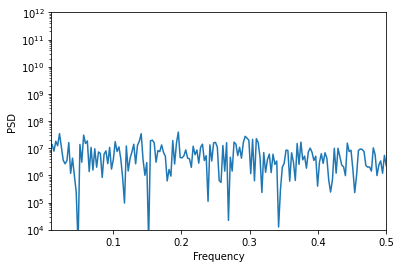

Strongest period length = 5.111111111111112


In [ ]:
f, PSD = scipy.signal.periodogram(jfk2017.Ridership)
plt.semilogy(f, PSD)
plt.xlabel('Frequency')
plt.ylabel('PSD')
plt.xlim(0.01,0.5)
plt.ylim(1e4,1e12)

PSD = PSD[f>0.01]; f = f[f>0.01]
plt.show()
print("Strongest period length = {}" .format(1/f[np.argmax(PSD)]))

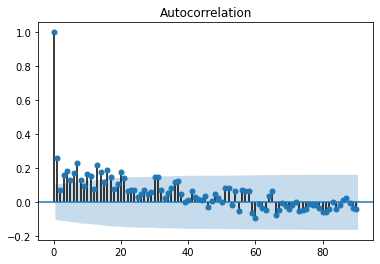

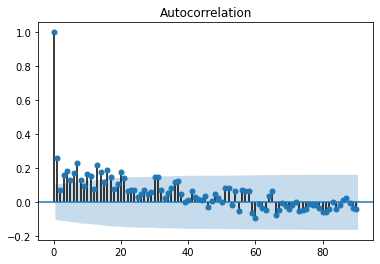

In [ ]:
plot_acf(jfk2017.Ridership, lags = 90)

### 3.3 Trend, seasonality, noise decomposition (using additive model) on 2017 data, period is from question 3.2 (3 pts)

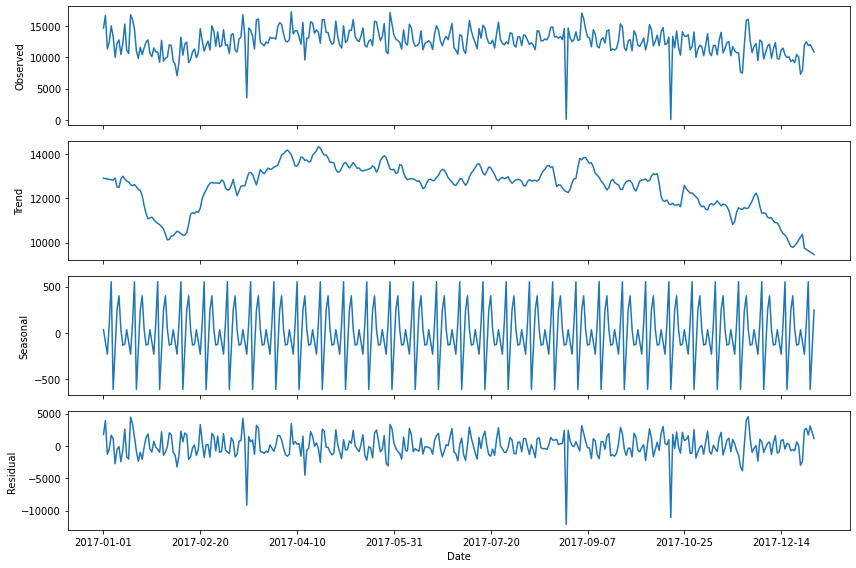

In [ ]:
matplotlib.rcParams['figure.figsize'] = [12, 8]
dailyDecomp = seasonal_decompose(jfk2017['Ridership'], model='additive', freq=12, extrapolate_trend='freq')
fig = dailyDecomp.plot()

## 4. Predict the total daily ridership from JFK using ARIMA.
ARIMA is a common method to predict taxi ridership. Before we predict taxi zone level hourly ridership, let's try to predict the aggregated daily ridership using ARIMA.

### 4.1 Using adfuller test to test the stability of the aggregated dataset. If not stable, apply differencing method until the p-value from adfuller test is smaller than 0.05. (3pts)

In [ ]:
from statsmodels.tsa.stattools import adfuller
series = daily17_18['Ridership']
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -2.318352
p-value: 0.166117
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569


### 4.2 Find out proper AR and MA terms in an ARIMA model using pacf and acf plots. (4 pts, 2 for each plot)
Hint: positive autocorrelation is usually best treated by adding an AR term to the model and negative autocorrelation is usually best treated by adding an MA term. In general, differencing reduces positive autocorrelation and may even cause a switch from positive to negative autocorrelation. 

Identifying the numbers of AR and MA terms:
1. if the pacf plot shows a sharp cutoff and/or the lag-1 autocorrelation is positive then consider adding one or more AR terms to the model. The lag beyond which the PACF cuts off is the indicated number of AR terms.

2. if the acf plot displays a sharp cutoff and/or the lag-1 autocorrelation is negative then consider adding an MA term to the model. The lag beyond which the ACF cuts off is the indicated number of MA terms.

3. It is generally advisable to stick to models in which at least one of AR and MA term is no larger than 1, i.e., do not try to fit a model such as ARIMA(2,1,2).

In [ ]:
jfk2017.head()

,Ridership
Date,
2017-01-01,14710
2017-01-02,16723
2017-01-14,11353
2017-01-15,12507
2017-01-16,15063


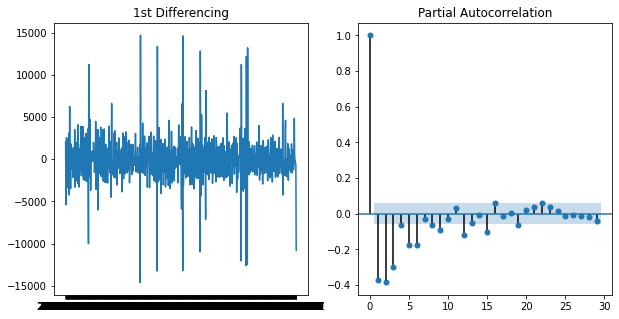

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
# AR
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].plot(daily17_18.Ridership.diff())
axes[0].set_title('1st Differencing')
# axes[1].set_ylim(0,1)
plot_pacf(daily17_18.Ridership.diff().dropna(), ax=axes[1],alpha=0.1) #plot differences between consequtive observations

plt.show()

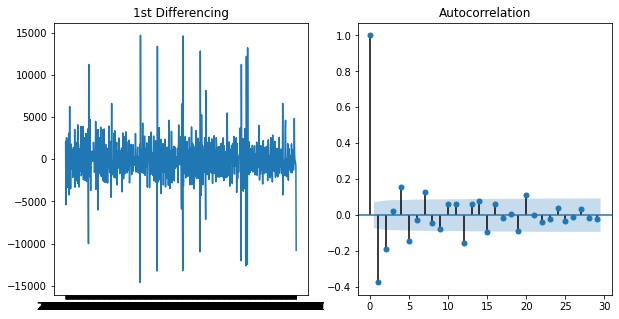

In [ ]:
# MA
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].plot(daily17_18.Ridership.diff()); axes[0].set_title('1st Differencing')
plot_acf(daily17_18.Ridership.diff().dropna(), ax=axes[1])

plt.show()

### 4.3 build an ARIMA model using terms from 4.2, training on the first 700 days, forecast on the last 31 days. Print ARIMA model results and plot in-sample and out-of-sample prediction in different colors. (8 pts, 3 for correct terms, 3 for training and summary, 2pts for the plot)

In [18]:
train = jfk_1718[:700]
test = jfk_1718[700:]

NameError: ignored

                             ARIMA Model Results                              
Dep. Variable:            D.Ridership   No. Observations:                   89
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -803.611
Method:                       css-mle   S.D. of innovations           2001.198
Date:                Sat, 12 Mar 2022   AIC                           1619.223
Time:                        00:35:19   BIC                           1634.154
Sample:                             1   HQIC                          1625.241
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -4.3331     34.017     -0.127      0.899     -71.005      62.339
ar.L1.D.Ridership     0.0871      0.134      0.649      0.518      -0.176       0.350
ar.L2.D.Ridership    -0.

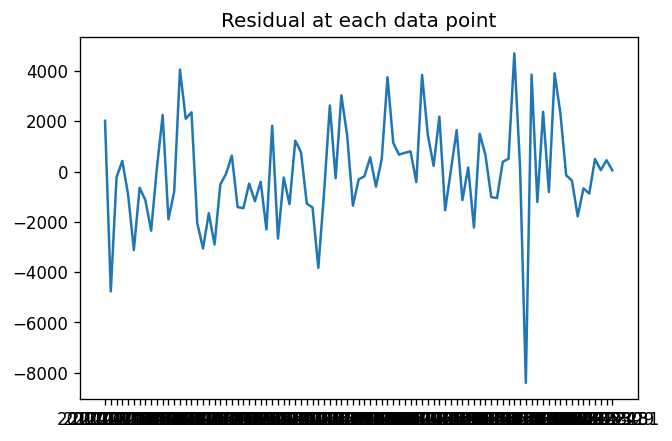

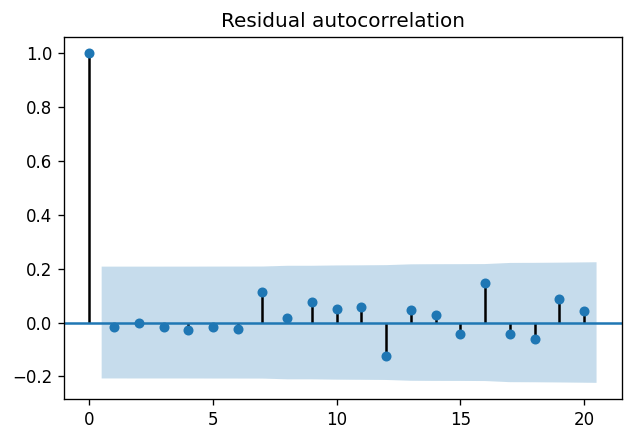

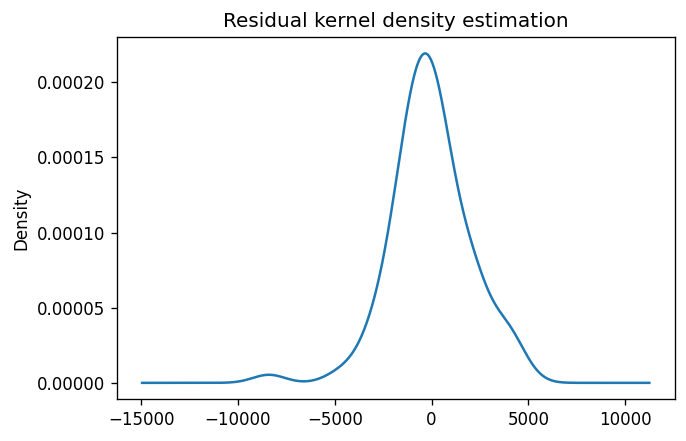

                 0
count    89.000000
mean    -60.205194
std    2043.334264
min   -8400.494750
25%   -1181.457285
50%    -187.934725
75%     799.367402
max    4695.355531
p value is  0.0023612737585928653
null hypothesis: residuals come from a normal distribution
The null hypothesis can be rejected
Ljung–Box:
(array([ 0.02331644,  0.02331644,  0.04429526,  0.12504452,  0.14723951,
        0.21006259,  1.51676141,  1.54111096,  2.14362723,  2.38821609,
        2.72171731,  4.31041446,  4.55306461,  4.63102224,  4.83816928,
        7.18842603,  7.39398397,  7.83072035,  8.70988185,  8.91338875,
        8.9137504 ,  8.92350179,  9.25024727, 10.34286596, 10.35587578,
       10.68902313, 10.89984684, 11.29631213, 13.04336671, 13.15483644,
       13.64606723, 13.86533791, 14.68231318, 17.73772926, 17.77644953,
       20.36848917, 20.40031089, 20.45402111, 20.56887026, 20.70452663]), array([0.87863705, 0.98840947, 0.99755324, 0.99812507, 0.99958012,
       0.99982148, 0.9817237 , 0.99200389, 

In [ ]:
# ARIMA model
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})

P=1
D=1
Q=3

# fit model
N=90   
series = daily17_18['Ridership']

#model = sm.tsa.SARIMAX(series[:N], order=(Q,D,P))
model = sm.tsa.ARIMA(series[:N], order=(Q,D,P))
model_fit = model.fit()
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
plt.plot(residuals)
plt.title('Residual at each data point')
plot_acf(residuals)
plt.title('Residual autocorrelation')
plt.show()
residuals.plot(kind='kde', legend=False)
plt.title('Residual kernel density estimation')
plt.show()
print(residuals.describe())
k2, p = scipy.stats.normaltest(residuals)
alpha = 0.1
print('p value is ',p[0])

print('null hypothesis: residuals come from a normal distribution')
if p < alpha:  
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
    
print("Ljung–Box:")
print(sm.stats.acorr_ljungbox(residuals))

# Taxi zone level prediction

This project aims to predict hourly yellow taxi ridership volume from JFK to each taxi zone. The ARIMA experiment in section 3 forecasts the total ridership amount from JFK. However, based on the reported $R^2$, this model is not a good fit. ARIMA model has four main shortcomings: 1) they rely heavily on stationarity assumption which does not hold in real-world traffic systems 2) they do not consider spatial and structural dependencies that traffic networks exhibit and forecast each sensor as an individual time series 3) they are unable to model non-linear temporal dynamics 4) they suffer from the curse of dimensionality. Due to the limitation of ARIMA, we need to apply another method to predict taxi zone level ridership.

## 5. Feature engineering

Our workflow is first standardizing the dataset, then using PCA to compress the dataset. As we predict future ridership, PCA should be learned from historical data (2017) then apply to the following year (2018). Next, add lag features (PCA components) from the past 12 hours and apply a Random Forest regressor to predict each PCA component's values in the next hour. After we had the PCA component prediction, inverse PCA, and inverse standardization to retrieve taxi ridership prediction in its original scale and dimension, in other words, we are predicting the PCA components instead of taxi zone level ridership and then using the inverse PCA method to reconstruct 

### 5.1. standardization. (3 pts)
The standardscaler stores information of this standardization process, including the mean and standard deviation values required when converting the prediction back to the raw scale. Split the whole dataset into two parts: 2017 and 2018, standardize each separately.

In [67]:
# load the whole dataset
from_jfk

,Date,Hour,Ridership
0,2017-01-01,00,527
23,2017-01-01,23,939
21,2017-01-01,21,1077
20,2017-01-01,20,1035
19,2017-01-01,19,1071
...,...,...,...
17521,2018-12-31,02,26
17519,2018-12-31,01,232
17518,2018-12-31,00,274
17531,2018-12-31,12,469


In [16]:
# split data - 2017 data
df_2017 = from_jfk[(from_jfk['Date'] >= '2017-01-01') & (from_jfk['Date'] <= '2017-12-31')]
df_2017 = df_2017.set_index('Date')
df_2017

,Hour,Ridership
Date,,
2017-01-01,00,527
2017-01-01,23,939
2017-01-01,21,1077
2017-01-01,20,1035
2017-01-01,19,1071
...,...,...
2017-12-31,06,471
2017-12-31,07,352
2017-12-31,08,354


In [17]:
# split data - 2018 data
df_2018 = from_jfk[(from_jfk['Date'] >= '2018-01-01') & (from_jfk['Date'] <= '2018-12-31')]
df_2018 = df_2018.set_index('Date')
df_2018

,Hour,Ridership
Date,,
2018-01-01,14,863
2018-01-01,15,988
2018-01-01,16,846
2018-01-01,17,822
2018-01-01,18,755
...,...,...
2018-12-31,02,26
2018-12-31,01,232
2018-12-31,00,274


In [69]:
# Standardize 2017 data
from sklearn import preprocessing
scaler2017 = preprocessing.StandardScaler().fit(df_2017)
df_2017S = scaler2017.transform(df_2017)

In [70]:
# Standardize 2018 data
from sklearn import preprocessing
scaler2018 = preprocessing.StandardScaler().fit(df_2018)
df_2018S = scaler2018.transform(df_2018)

### 5.2. PCA

#### 5.2.1 train PCA on 2017 data. Let's arbitrarily set PCA components as 5, and gamma is None, try kernel ‘linear’, ‘poly’, ‘rbf’, and ‘sigmoid’. Select the transformer which has the lowest mean squared error in data reconstruction (inverse transform). (5 pts)

In [71]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA, KernelPCA
# train PCA on 2017 data 
kpca=KernelPCA(kernel='linear',gamma=None,n_components=5,fit_inverse_transform=True)
rbf_kpca=kpca.fit_transform(df_2017S)

rbf_pca_inverse=kpca.inverse_transform(rbf_kpca)
mse = mean_squared_error(df_2017S, rbf_pca_inverse)
print(mse)

2.9481211254792198e-08


In [72]:
kpca=KernelPCA(kernel='poly',gamma=None,n_components=5,fit_inverse_transform=True)
rbf_kpca=kpca.fit_transform(df_2017S)

rbf_pca_inverse=kpca.inverse_transform(rbf_kpca)
mse = mean_squared_error(df_2017S, rbf_pca_inverse)
print(mse)

5.0201218883843494e-05


In [48]:
kpca=KernelPCA(kernel='rbf',gamma=None,n_components=5,fit_inverse_transform=True)
rbf_kpca=kpca.fit_transform(df_2017S)

rbf_pca_inverse=kpca.inverse_transform(rbf_kpca)
mse = mean_squared_error(df_2017S, rbf_pca_inverse)
print(mse)

0.00891108115596646


In [49]:
kpca=KernelPCA(kernel='sigmoid',gamma=None,n_components=5,fit_inverse_transform=True)
rbf_kpca=kpca.fit_transform(df_2017S)

rbf_pca_inverse=kpca.inverse_transform(rbf_kpca)
mse = mean_squared_error(df_2017S, rbf_pca_inverse)
print(mse)

LinAlgError: ignored

#### 5.2.2 Apply the selected transformer from 4.2.1 to the standardized 2018 dataset and report the mean squared error between the standardized data and reconstructed data. Hint: fit the PCA on 2017 data and apply it to transform 2018 data.(5pts)

In [64]:
kpca=KernelPCA(kernel='rbf',gamma=None,n_components=5,fit_inverse_transform=True)
rbf_kpca=kpca.fit_transform(df_2018S)

rbf_pca_inverse=kpca.inverse_transform(rbf_kpca)
mse = mean_squared_error(df_2018S,rbf_pca_inverse)
print(mse)

0.008626383276760886


### 5.3 Add lag (5pts)
add 12 lags of each component from 5.2.2 (compressed 2018 data only). The expected output should have 65 dimensions. In the further modeling step, we will apply the 60 lag variables to predict the 5 components.

In [68]:
df_2018S

,0,1,lag01,lag02,lag03,lag04,lag05,lag06,lag07,lag08,...,lag13,lag14,lag15,lag16,lag17,lag18,lag19,lag110,lag111,lag112
0,0.361158,1.373708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.505621,1.826238,0.361158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.650084,1.312164,0.505621,0.361158,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.794547,1.225278,0.650084,0.505621,0.361158,NaN,NaN,NaN,NaN,NaN,...,1.373708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.939010,0.982722,0.794547,0.650084,0.505621,0.361158,NaN,NaN,NaN,NaN,...,1.826238,1.373708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,-1.372399,-1.656434,-1.227936,-1.083473,-0.939010,-0.794547,-0.505621,-0.361158,-0.072232,-0.216695,...,-0.563121,-0.164895,0.074041,-0.545020,-0.635526,-0.555880,0.269534,-0.320565,0.284015,0.884975
8756,-1.516862,-0.910664,-1.372399,-1.227936,-1.083473,-0.939010,-0.794547,-0.505621,-0.361158,-0.072232,...,-1.536966,-0.563121,-0.164895,0.074041,-0.545020,-0.635526,-0.555880,0.269534,-0.320565,0.284015
8757,-1.661325,-0.758614,-1.516862,-1.372399,-1.227936,-1.083473,-0.939010,-0.794547,-0.505621,-0.361158,...,-1.442839,-1.536966,-0.563121,-0.164895,0.074041,-0.545020,-0.635526,-0.555880,0.269534,-0.320565
8758,0.072232,-0.052667,-1.661325,-1.516862,-1.372399,-1.227936,-1.083473,-0.939010,-0.794547,-0.505621,...,-1.656434,-1.442839,-1.536966,-0.563121,-0.164895,0.074041,-0.545020,-0.635526,-0.555880,0.269534


In [57]:
df_2017S = pd.DataFrame(df_2017S)
df_2017S

,0,1
0,-1.661325,0.007648
1,1.661325,1.393814
2,1.372399,1.858112
3,1.227936,1.716804
4,1.083473,1.837925
...,...,...
8755,-0.794547,-0.180762
8756,-0.650084,-0.581135
8757,-0.505621,-0.574407
8758,-0.361158,-1.005060


In [66]:
df_2018S = pd.DataFrame(df_2018S)
df_2018S

,0,1
0,0.361158,1.373708
1,0.505621,1.826238
2,0.650084,1.312164
3,0.794547,1.225278
4,0.939010,0.982722
...,...,...
8755,-1.372399,-1.656434
8756,-1.516862,-0.910664
8757,-1.661325,-0.758614
8758,0.072232,-0.052667


In [67]:
M=12
for p in range(1,M+1): 
    df_2018S['lag0%d'%p]=df_2018S[0].shift(p)



M=12
for p in range(1,M+1): 
    df_2018S['lag1%d'%p]=df_2018S[1].shift(p)

M=12
for p in range(1,M+1): 
    df_2018S['lag2%d'%p]=df_2018S[2].shift(p)

M=12
for p in range(1,M+1): 
    df_2018S['lag3%d'%p]=df_2018S[3].shift(p)

M=12
for p in range(1,M+1): 
    df_2018S['lag4%d'%p]=df_2018S[4].shift(p)

df_2018S=df_2018S.fillna(0)

df_2018S

KeyError: ignored

## 6. RandomForest modeling (23pts)

We aim at predicting compressed daily ridership (5 PCA components values) from 12-hour lag variables. Parameter tuning is required in this section, including min_samples_split, min_samples_leaf, and n_estimators. First 80% days for training, test on the rest 20%. And in the training dataset, validate the model on the bottom 20%. 


### Extra credit: 

Using grid_search function in sklearn instead of a for-loop when tuning parameters in a RandomForest. The train, validation, and test datasets should be split in the same way as described above. Hint: To fix train and validation in a grid search, you might need the PredefinedSplit function from sklearn.

### 6.1 train test split (3pts)
Please keep in mind that random train test split is not applicable in this case.

In [ ]:
## train-test split

X_train,X_test, y_train,y_test=train_test_split(X,y ,test_size=0.2,random_state=0) 

### 6.2 parameter tuning (10pts)
Please search the best parameter set in the following range:
min_samples_split: 2 to 10,
min_samples_leaf: 2 to 10,
and n_estimators equal to 50.


### 6.3 model performance measurement (10pts)
Prediction results are PCA components instead of taxi zone level ridership. To reconstruct the data back to its original size and scale, we need to inverse PCA and inverse standardization. Report the taxi zone level $R^2$ value.